In [1]:
#!apt-get install git
#!pip install opencv-python

## Original Notebook classifying all 4 classes:
- 0 : Glioma Tumor
- 1 : Meningioma Tumor
- 2 : No Tumor
- 3 : Pituitary Tumor

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
import random
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Data Source: [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

In [5]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Testing'

In [6]:
!nvidia-smi

Tue Jan  9 11:30:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

We can see from the above output that Tensorflow is utilising the NVIDIA Tesla T4 GPU.

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
# Checking to see the different folders within our path
for image_class in os.listdir(training_path):
  print(image_class)


glioma_tumor
pituitary_tumor
no_tumor
meningioma_tumor


In [15]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

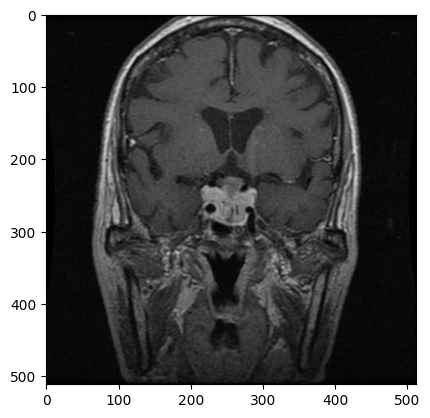

In [16]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

In [17]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']
# for image_class in os.listdir(training_path):
#   for image in os.listdir(os.path.join(training_path, image_class)):
#     image_path = os.path.join(training_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

In [18]:
# for image_class in os.listdir(testing_path):
#   for image in os.listdir(os.path.join(testing_path, image_class)):
#     image_path = os.path.join(testing_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

The above code can be used to verify the extention of images, and filter out those with inapropriate extentions. In this dataset the images were all .jpg format, and thus the code did not need to be utilised

# Loading data

The datset was already split into testing and training data so we do not need to define these later

In [19]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256), # We are adjusting the images so they becoem 256x256 images instead.
    batch_size=32,
    validation_split=0.2, # We will utilise 20% of the data from the training data for validation.
    subset='training',
    seed=42
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
)

Found 2910 files belonging to 4 classes.
Using 2328 files for training.
Found 2910 files belonging to 4 classes.
Using 582 files for validation.
Found 394 files belonging to 4 classes.


In [20]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()
batch_training = Training_iterator.next()


In [24]:
batch_training[0].shape # Images are now of dimension 256 x 256

(32, 256, 256, 3)

In [25]:
batch_training[1] # Labels are 0,1,2 and 3 for the different classes

array([1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 2,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 3], dtype=int32)

In [26]:
# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


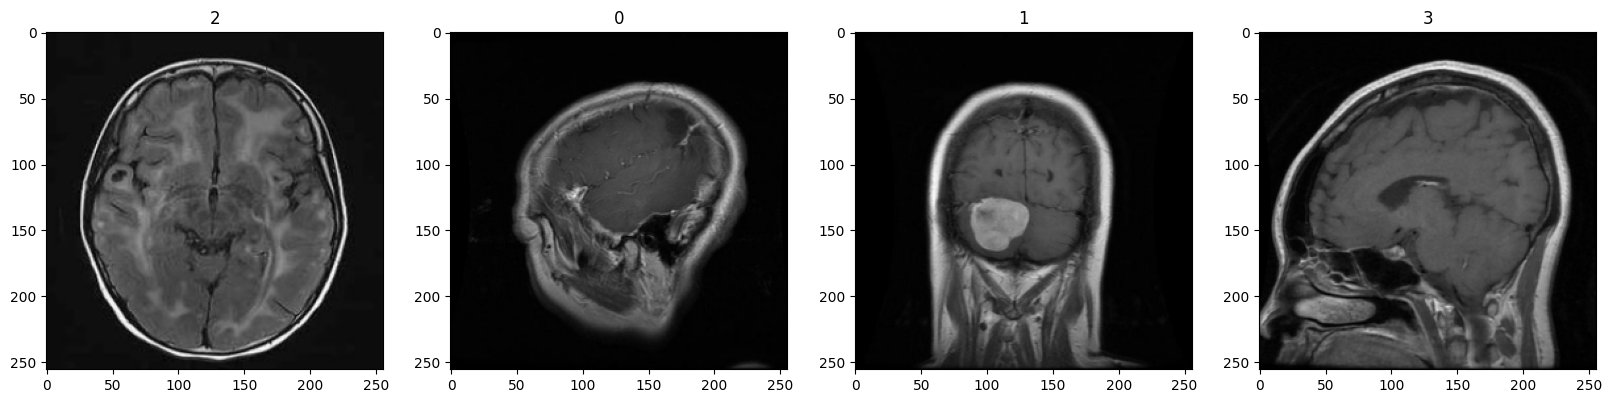

In [27]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


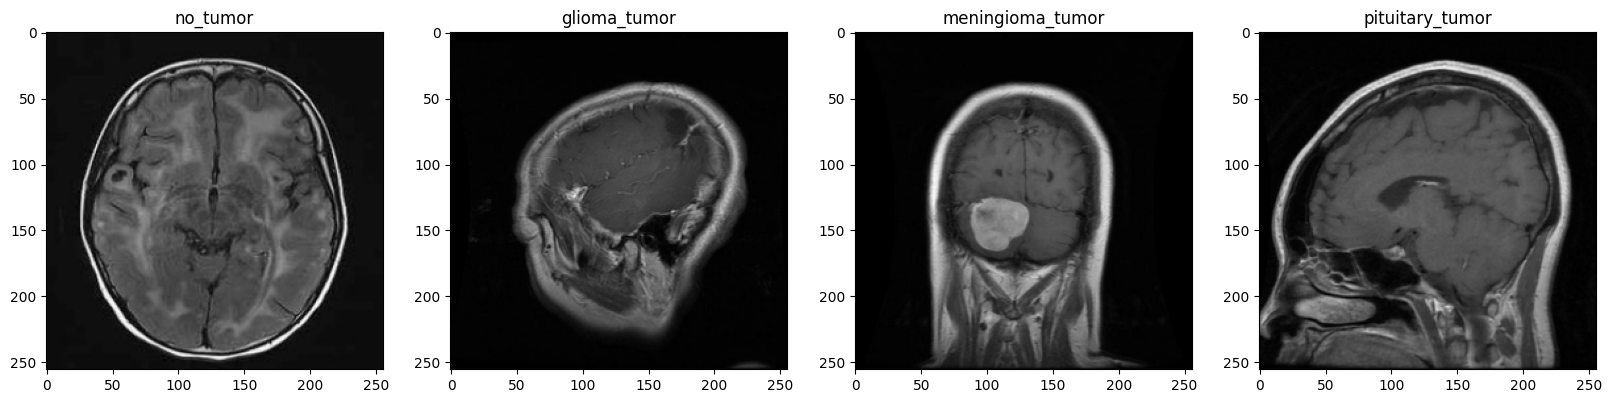

In [28]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(class_names[batch_training[1][img_index]])

# Preprocessing Data

In [29]:
def augment_image(x, y):
    # Probability of applying augmentation is 0.5, We don't want to apply augmentation to all images, only some.

    apply_augmentation = tf.random.uniform(shape=[], minval=0.0, maxval=1.0) > 0.5
    if apply_augmentation:
        augmentations = [
            lambda x: tf.image.random_flip_left_right(x),
            lambda x: tf.image.random_flip_up_down(x),
            lambda x: tf.image.rot90(x, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)),
          #  lambda x: tf.image.central_crop(x, central_fraction=tf.clip_by_value(tf.random.uniform(shape=[], minval=0.8, maxval=1.2), 0.0, 1.0)),
        ]

        selected_augmentation = random.choice(augmentations)
        # Apply the selected augmentation to the image
        x = selected_augmentation(x)
    return x, y


In [30]:
num_classes = 4

# Load the training dataset
Training_data = Training_data.map(augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the validation dataset
Validation_data = Validation_data.map(augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
Validation_data = Validation_data.map(augment_image)
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is Labels


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


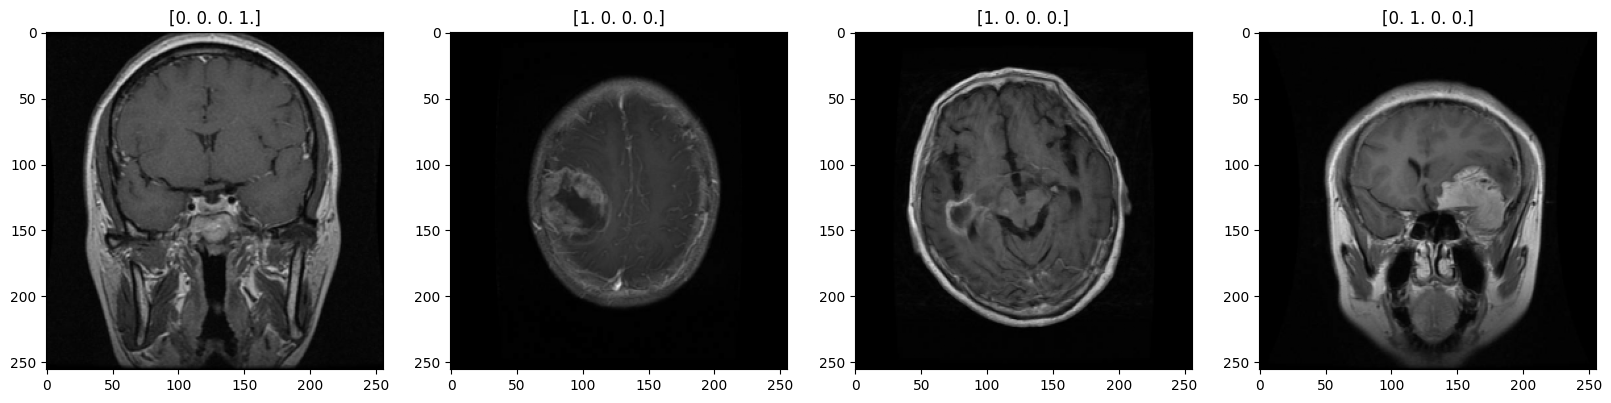

In [33]:
batch_training = Training_data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index])
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   [1,0,0,0] : Glioma Tumor
-   [0,1,0,0]  : Meningioma Tumor
-   [0,0,1,0]  : No Tumor
-   [0,0,0,1]  : Pituitary Tumor


# Deep Model

In [346]:
model = Sequential()

# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(rate =0.1))

model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(rate=0.1))

model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(rate=0.1))


# Final layer that gives a single output and represets the label
model.add(Dense(4, activation = 'softmax'))

In [347]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [348]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 30, 30, 64)      

## Training

In [349]:
logdir = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [351]:
hist = model.fit(Training_data, epochs = 30, validation_data = Validation_data, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/30
73/73 [==============================] - 14s 137ms/step - loss: 1.7464 - accuracy: 0.4759 - val_loss: 1.4404 - val_accuracy: 0.5120
Epoch 2/30
73/73 [==============================] - 9s 123ms/step - loss: 1.3609 - accuracy: 0.5498 - val_loss: 1.2073 - val_accuracy: 0.6014
Epoch 3/30
73/73 [==============================] - 10s 132ms/step - loss: 1.1359 - accuracy: 0.6564 - val_loss: 1.0253 - val_accuracy: 0.6821
Epoch 4/30
73/73 [==============================] - 11s 144ms/step - loss: 1.0303 - accuracy: 0.6894 - val_loss: 1.0172 - val_accuracy: 0.6649
Epoch 5/30
73/73 [==============================] - 9s 121ms/step - loss: 0.9210 - accuracy: 0.7272 - val_loss: 0.8890 - val_accuracy: 0.7251
Epoch 6/30
73/73 [==============================] - 11s 134ms/step - loss: 0.8633 - accuracy: 0.7547 - val_loss: 0.8507 - val_accuracy: 0.7698
Epoch 7/30
73/73 [==============================] - 13s 171ms/step - loss: 0.8019 - accuracy: 0.7942 - val_loss: 0.7878 - val_accuracy: 0.7766
E

## Model Evaluation

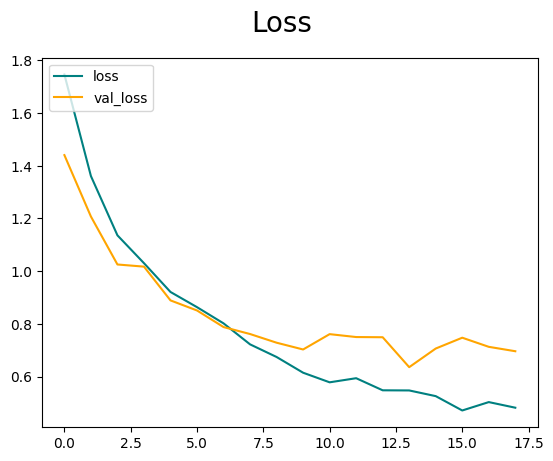

In [353]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

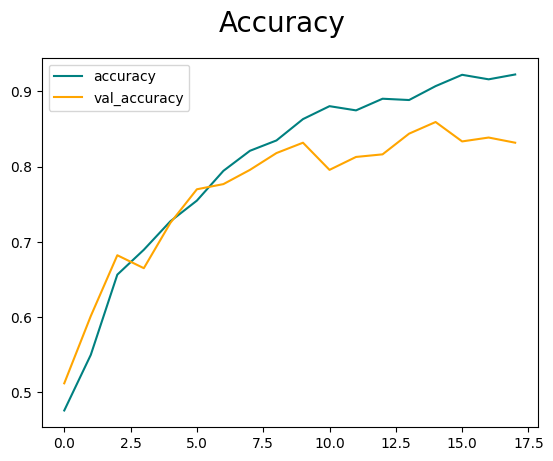

In [354]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Testing data

In [355]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [356]:
labels_testing = []
X_test =[]

for batch in Testing_data.as_numpy_iterator():
    x_test, y_test = batch
    y_test = [np.where(row == 1)[0][0].tolist() for row in y_test] # Gets the position of the 1 to determine the type of tumor and assigns to a list
    labels_testing.extend(y_test)
    X_test.extend(x_test)

labels_testing = np.array(labels_testing) # Full y_test labels transformed
X_test = np.array(X_test) # Full X_test data

In [357]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
y_ = labels_testing # Our true y values
yhat_ =[] # Empty list for predicted variables

yhat = model.predict(X_test)
yhat_binary = np.argmax(yhat, axis=1) # gets value of 1 and position
yhat_.append(yhat_binary)

pre.update_state(y_, yhat_binary)
re.update_state(y_, yhat_binary)
acc.update_state(y_, yhat_binary)

In [359]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.7762803435325623
Recall: 0.9795918464660645
Accuracy: 0.32487308979034424


### Confusion Matrix

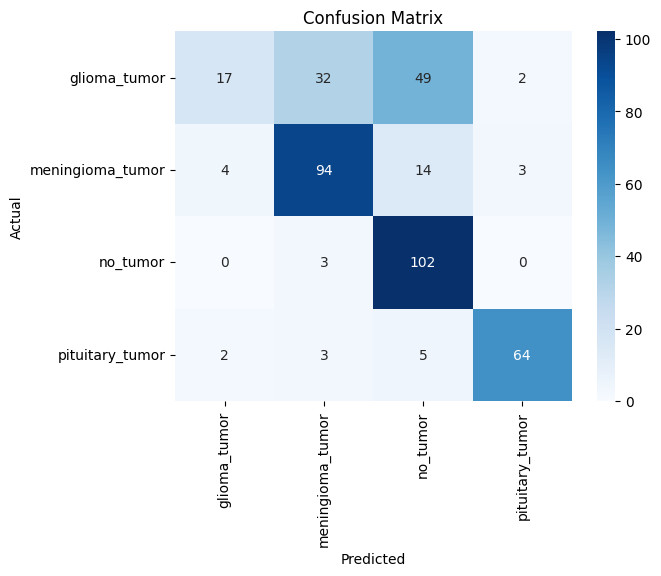

In [360]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_, yhat_binary)

sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can say that while Meningioma, Pituitary, and No tumor are being picked up well, Glioma tumor however isn't so easily and is something that would require future work

## Saving model

In [363]:
model.save('/content/drive/MyDrive/projects/Brain_Tumor_Classification/model')